Our first task is to use the table of user engagement to identify 'adopted users.' An adopted user has logged in three separate days in at least one seven day period, accomplished using a rolling 7 day window for each user.

To make a predictions, I made some changes to the feature columns. First off, I eliminated the two date columns since they carried time dependent information that could be highly correlated with the target variable. Next, I wanted to use the 'invited by user id' column, but there were too many different values, and it would cause significant issues with a decision tree of regression model. I therefore chose to make this column True if they had been invited by any user and False if the column contained NaN. Finally, I encoded the 'creation source' column as dummy variables.

I put the data into a decision tree model, with default parameters. Precursoy tuning of parameters had little effect on the outcome. Since the data is highly unbalanced (about 13% of users adopted), precision and recall are more appropriate metrics. From a classification report, I can see that the precision on the 'adopted' class is 15% which is only slightly better than guessing that every user adopted. Though, since the recall is not 100%, it is important to note this is not the conclusion the algorithm drew. The ROC curve is also just slightly better than guessing.

Looking at the feature importance parameters for the model a 'creation source' column of 'personal projects' by far has the most predictive power. The rest of the features are very low in terms of importance. For future work to improve predictions, I would focus on feature engineering to try to get more information into the model. For example, individual user invites and groups could be put into the random tree model through binary encoding. Also, since many features seem to have trouble splitting the users into categories, boosting algorithms that improve the performance of ensembles of weak predictors might be helpful. Finally, looking for additional data that could be gathered may also help.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
users_file = 'takehome_users.csv'
user_engagement_file = 'takehome_user_engagement.csv'
df_users = pd.read_csv(users_file,index_col=0,encoding='cp437')
df_user_engagement = pd.read_csv(user_engagement_file,
                                 index_col = [1,0],
                                 encoding = 'cp437')
user_ids = pd.read_csv(user_engagement_file,
                       index_col = False,
                       usecols = [1],
                       squeeze = True
                      )
user_ids = user_ids.unique()

In [3]:
adopted_user = []
for user in user_ids:
    df_logins = df_user_engagement.loc[user,:]
    df_logins.index = pd.to_datetime(df_logins.index,format = '%Y-%m-%d %H:%M:%S')
    df_logins = df_logins.rolling('7D').sum()
    if len(df_logins[df_logins.visited >= 3]) > 0:
        adopted_user.append(user)

In [4]:
df_users['is_adopted'] = False
df_users.loc[adopted_user,'is_adopted'] = True
df_users.loc[:,'invited_by_user_id'] = pd.notna(df_users.invited_by_user_id)

In [5]:
features = ['creation_source',
            'opted_in_to_mailing_list',
            'enabled_for_marketing_drip',
            'invited_by_user_id'
           ]

df_users["creation_source"] = pd.Categorical(df_users.creation_source, 
                                   categories=df_users.creation_source.unique(),
                                   ordered=False)

df_features = pd.get_dummies(df_users.loc[:,features],prefix='creation_source',columns=['creation_source'],dummy_na=False)
df_target = df_users.loc[:,'is_adopted']

features = np.array(df_features)
feature_names = df_features.columns
target = np.array(df_target)

In [6]:
#Split into test/train
n_obs = features.shape[0]
n_train = round(0.7*n_obs)
shuffle_index = np.random.choice(range(n_obs), size = n_obs, replace = False)
train_index = shuffle_index[:n_train]
test_index = shuffle_index[n_train:]

#Create X and y arrays
features_train = features[train_index,:]
features_test = features[test_index,:]

target_train = target[train_index]
target_test = target[test_index]

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model = DecisionTreeClassifier(criterion = 'entropy',
                               min_samples_split = 20,
                               class_weight = 'balanced')

model.fit(features_train,target_train)
target_predict = model.predict(features_test)

print(classification_report(target_test,
                            target_predict,
                            target_names = ['Did not adopt','Adopted']))

for i,feature in enumerate(feature_names):
    print(feature,model.feature_importances_[i],'\n')

               precision    recall  f1-score   support

Did not adopt       0.88      0.38      0.53      3105
      Adopted       0.15      0.67      0.24       495

    micro avg       0.42      0.42      0.42      3600
    macro avg       0.51      0.52      0.38      3600
 weighted avg       0.78      0.42      0.49      3600

opted_in_to_mailing_list 0.07599097713231728 

enabled_for_marketing_drip 0.04092628046851875 

invited_by_user_id 0.0 

creation_source_GUEST_INVITE 0.06927802245723308 

creation_source_ORG_INVITE 0.006662201798968691 

creation_source_SIGNUP 0.0007790287411119772 

creation_source_PERSONAL_PROJECTS 0.6857244752951984 

creation_source_SIGNUP_GOOGLE_AUTH 0.12063901410665182 



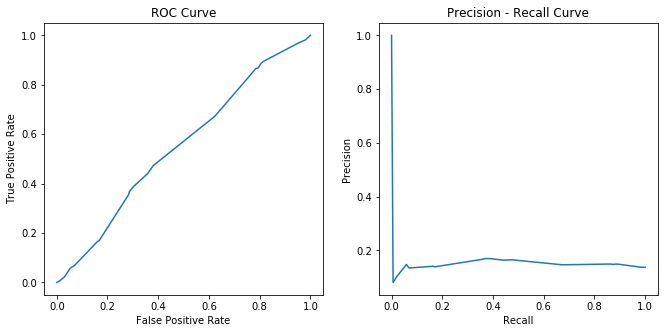

In [8]:
from sklearn.metrics import precision_recall_curve, roc_curve

target_probs = model.predict_proba(features_test)[:,1]
precision, recall,thresholds = precision_recall_curve(target_test,target_probs)
fpr, tpr, thresholds = roc_curve(target_test, target_probs)

fig = plt.figure(figsize = [11,5])
ax1 = plt.subplot(1,2,1)
ax1.plot(fpr,tpr)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')

ax2 = plt.subplot(1,2,2)
ax2.plot(recall,precision)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision - Recall Curve')
plt.show()